# Feature engineering

In [27]:
import os 
import gc 
import numpy as np 
import pandas as pd 
import json 
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
import matplotlib.pyplot as plt

%matplotlib inline

warnings.simplefilter('ignore')

In [2]:

def load_data(path, nrows=None):

    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(path, dtype={
        'fullVisitorId': 'str', 'visitId': 'str'}, 
        nrows=nrows,
        converters={column: json.loads for column in json_cols},
        engine="c")

    for col in json_cols:
        col_as_df = json_normalize(df[col])
        col_as_df.columns = [f'{col}.{subcolumn}' 
            for subcolumn in col_as_df.columns]
        df = df.drop(col, axis=1).merge(col_as_df, right_index=True, left_index=True)
    
    print(f"Loaded {os.path.basename(path)}, data shape: {df.shape}")
    return df 


def tidy_data(df):

    # Convert target into log scale
    y_name = 'totals.transactionRevenue'
    df[y_name] = df[y_name].astype(float)
    df[y_name+'_log'] = np.log1p(df[y_name])

    # Remove columns that has const value. May be indicate blank value
    na_vals = ['unknown.unknown', '(not set)', 'not available in demo dataset', 
        '(not provided)', '(none)', '<NA>']
    for c in df.columns:
        is_na = df[c].isin(na_vals)
        df.loc[is_na, c] = np.nan
    const_cols = [c for c in df.columns if df[c].notnull().sum() == 0]
    print(f"Only NA value column list: {const_cols}")
    df.drop(const_cols, axis=1, inplace=True)

    # Drop duplicate meaning of columns
    # Todo: date column could be add to test
    sc = ['date', 'sessionId', 'socialEngagementType']
    print(f"No use columns: {sc}")
    df.drop(sc, axis=1, inplace=True)

    # Convert to should-be-like dtype
    df['visitStartTime'] = pd.to_datetime(
        df['visitStartTime'].astype(int).astype(str), unit='s')

    df['visitId'] = df['visitId'].astype("int64")
    
    # device section
    df['device.isMobile'] = df['device.isMobile'].astype("int8")

    # totals section
    sc = [c for c in df.columns if c.startswith('totals.')]
    for c in sc:
        df[c] = df[c].astype(float)

    # trafficSource section
    # sc = [c for c in df.columns if c.startswith("trafficSource")]

    return df


In [20]:
    DBG = True
    np.random.seed(123)
    nrows = 10000 if DBG else None

    train = load_data('../input/train.csv', nrows)
    sc = ['fullVisitorId', 'visitStartTime']
    train = train.sort_values(sc).reset_index(drop=True)
    test = load_data('../input/test.csv', nrows)
    test = test.sort_values(sc).reset_index(drop=True)

    y_name = 'totals.transactionRevenue'
    test[y_name] = 0
    tr_n = train.shape[0]
    train = train[test.columns.tolist()]
    # train = train.append(test, ignore_index=True)
    # How much visitor intersect between train and test dataset?
    train_user = set(train["fullVisitorId"].tolist())
    test_user = set(test["fullVisitorId"].tolist())
    cm_user = train_user & test_user
    idx = (train["fullVisitorId"].isin(cm_user)) & (pd.to_numeric(train[y_name]) > 0)
    print(f"train user count: {len(train_user)}, test user count: {len(test_user)},\n\
Common user cnt: {len(cm_user)} and common user with revenue count: {idx.sum()}")
    df = train.append(test, ignore_index=True)
    print(f"current data shape: {df.shape}")
    del train, test
    gc.collect()

Loaded train.csv, data shape: (10000, 54)
Loaded test.csv, data shape: (10000, 53)
train user count: 9251, test user count: 9142,
Common user cnt: 9 and common user with revenue count: 0
current data shape: (20000, 54)


98

In [31]:
df = tidy_data(df)
df.describe()

Only NA value column list: ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.criteriaParameters']
No use columns: ['date', 'sessionId', 'socialEngagementType']


,visitId,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,totals.transactionRevenue,totals.transactionRevenue_log
count,2.000000e+04,20000.000000,20000.000000,10343.0,20000.000000,15002.0,19999.000000,20000.0,1.009100e+04,10091.000000
mean,1.499342e+09,2.284550,0.305150,1.0,4.492000,1.0,3.730487,1.0,1.055806e+06,0.160248
std,1.561948e+07,7.724142,0.460482,0.0,8.638875,0.0,6.156351,0.0,1.982039e+07,1.684302
min,1.472799e+09,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,0.000000e+00,0.000000
25%,1.486122e+09,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,0.000000e+00,0.000000
50%,1.503212e+09,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,0.000000e+00,0.000000
75%,1.512038e+09,1.000000,1.000000,1.0,4.000000,1.0,4.000000,1.0,0.000000e+00,0.000000
max,1.523862e+09,401.000000,1.000000,1.0,189.000000,1.0,138.000000,1.0,1.077000e+09,20.797445


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 35 columns):
channelGrouping                                 20000 non-null object
fullVisitorId                                   20000 non-null object
visitId                                         20000 non-null int64
visitNumber                                     20000 non-null float64
visitStartTime                                  20000 non-null datetime64[ns]
device.browser                                  20000 non-null object
device.deviceCategory                           20000 non-null object
device.isMobile                                 20000 non-null int8
device.operatingSystem                          19875 non-null object
geoNetwork.city                                 8065 non-null object
geoNetwork.continent                            19979 non-null object
geoNetwork.country                              19979 non-null object
geoNetwork.metro                              

In [33]:
df.head()

,channelGrouping,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,...,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,totals.transactionRevenue,totals.transactionRevenue_log
0,Social,0000245437374675368,1472862842,1.0,2016-09-03 00:34:02,Internet Explorer,desktop,0,Windows,NaN,...,NaN,NaN,NaN,NaN,NaN,referral,/yt/about/,youtube.com,NaN,NaN
1,Organic Search,0000750929315523353,1486157741,1.0,2017-02-03 21:35:41,Safari,desktop,0,Macintosh,NaN,...,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,NaN,NaN
2,Social,0004803397127474847,1472824907,1.0,2016-09-02 14:01:47,Chrome,desktop,0,Windows,NaN,...,NaN,NaN,NaN,NaN,NaN,referral,/yt/about/,youtube.com,NaN,NaN
3,Direct,0005096736076850458,1472841336,1.0,2016-09-02 18:35:36,Chrome,desktop,0,Windows,Buenos Aires,...,NaN,NaN,NaN,True,NaN,NaN,NaN,(direct),NaN,NaN
4,Direct,0005096736076850458,1472843606,2.0,2016-09-02 19:13:26,Chrome,desktop,0,Windows,Buenos Aires,...,NaN,NaN,NaN,True,NaN,NaN,NaN,(direct),NaN,NaN


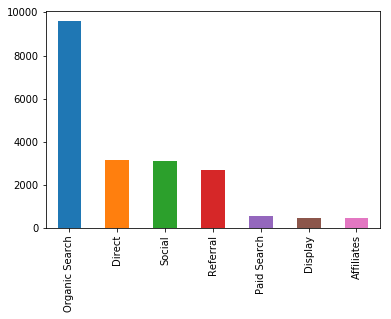

In [30]:
df['channelGrouping'].fillna('NAN').value_counts().plot(kind='bar')

In [39]:
import math
df['visitId'].quantile(np.arange(0, 1.01, 0.1))

0.0    1.472799e+09
0.1    1.472858e+09
0.2    1.485465e+09
0.3    1.486181e+09
0.4    1.498206e+09
0.5    1.503212e+09
0.6    1.508192e+09
0.7    1.510342e+09
0.8    1.512065e+09
0.9    1.523781e+09
1.0    1.523862e+09
Name: visitId, dtype: float64

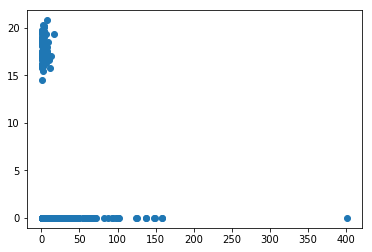

In [45]:
plt.scatter(df['visitNumber'].fillna(0), df[y_name + '_log'])

In [76]:
# map visit start time into local time
import googlemaps
from datetime import datetime
import json

with open('.secret.json') as f:
    # Setting up API key
    pk = json.load(f)
    
# print(pk)
gmaps = googlemaps.Client(key=pk['key'])

# 
# dir(gmaps)

In [ ]:
res = gmaps.geocode('1600 Amphitheatre Parkway, Mountain View, CA')
print(res)

timez = gmaps.timezone(location=res[0]['geometry']['location'])
print(timez)

In [71]:
addr = df[['geoNetwork.city', 'geoNetwork.region', 'geoNetwork.country']].fillna('').apply(lambda x: ' '.join(x), axis=1)
print(f"Empty addr count: {(addr == '').sum()}")

Empty addr count: 0


In [54]:
addr.head()

0                          United States
1                          United States
2                              Australia
3    Buenos Aires Buenos Aires Argentina
4    Buenos Aires Buenos Aires Argentina
dtype: object

In [ ]:
d = {}
for c in addr.unique().tolist():
    geo_res = gmaps.geocode(c)
    timez = gmaps.timezone(location=geo_res[0]['geometry']['location'])
    d[c] = timez

In [ ]:
# map back the hour


In [80]:
df['visitHour'] = df['visitStartTime'].dt.hour
df['visitDay'] = df['visitStartTime'].dt.day
df['visitDOW'] = df['visitStartTime'].dt.dayofweek
df[['visitStartTime', 'visitHour', 'visitDay', 'visitDOW']].head()

,visitStartTime,visitHour,visitDay,visitDOW
0,2016-09-03 00:34:02,0,3,5
1,2017-02-03 21:35:41,21,3,4
2,2016-09-02 14:01:47,14,2,4
3,2016-09-02 18:35:36,18,2,4
4,2016-09-02 19:13:26,19,2,4


In [42]:
df.columns

Index(['channelGrouping', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'totals.transactionRevenue',
       'totals.transactionRevenue_log'],
   